In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.3.0 cuda: True


In [2]:
%run PARAMETERS.py
NAME = 'APG'
PATH = NAME + '-bmnist-3digits-galileo-96'
CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda:1')

Viz_INTERVAL = 5
FS = 30*1.5
TITLE_FS = 20
LW= 3
COLORS = ['#AA3377', '#EE7733', '#009988', '#0077BB', '#BBBBBB', '#EE3377', '#DDCC77']

In [3]:
from model_operations import Init_models, Save_models
models, AT = Init_models(K=K,
                         D=D,
                         FRAME_PIXELS=FRAME_PIXELS, 
                         DIGIT_PIXELS=DIGIT_PIXELS, 
                         HIDDEN_LIST=HIDDEN_LIST, 
                         CUDA=CUDA, 
                         DEVICE=DEVICE, 
                         lr=LEARNING_RATE, 
                         Test=True, 
                         RESTORE=True, 
                         PATH=PATH)

mnist_mean = mnist_mean.cuda().to(DEVICE)

In [4]:
K_test= 3
T_test =100
DATA_PATH_test = "/data/hao/apg_data/mnist/test_T%dD%d/" % (T_test, K_test)

In [5]:
from apg_galileo import APG
from viz_mc import Viz_MC
from testing import Eval

apg = APG(models=models, 
          AT=AT, 
          K=K_test, 
          T=T_test, 
          mnist_mean=mnist_mean, 
          frame_size=FRAME_PIXELS,
          training=False)

APG_STEPS = 5

evaluator = Eval(APG=apg,
                 APG_STEPS=APG_STEPS, 
                 S=5,
                 DATA_PATH=DATA_PATH_test,
                 DEVICE=DEVICE)

visualizer = Viz_MC(K=K, 
                    viz_interval=Viz_INTERVAL, 
                    FS=FS, 
                    TITLE_FS=TITLE_FS, 
                    COLORS=COLORS,
                    LW=LW)

In [7]:
GROUP_PTR = 0
DATA_PTR= 10


Metrics = evaluator.Test_single_video(group_ptr=GROUP_PTR, 
                                      data_ptr=DATA_PTR)

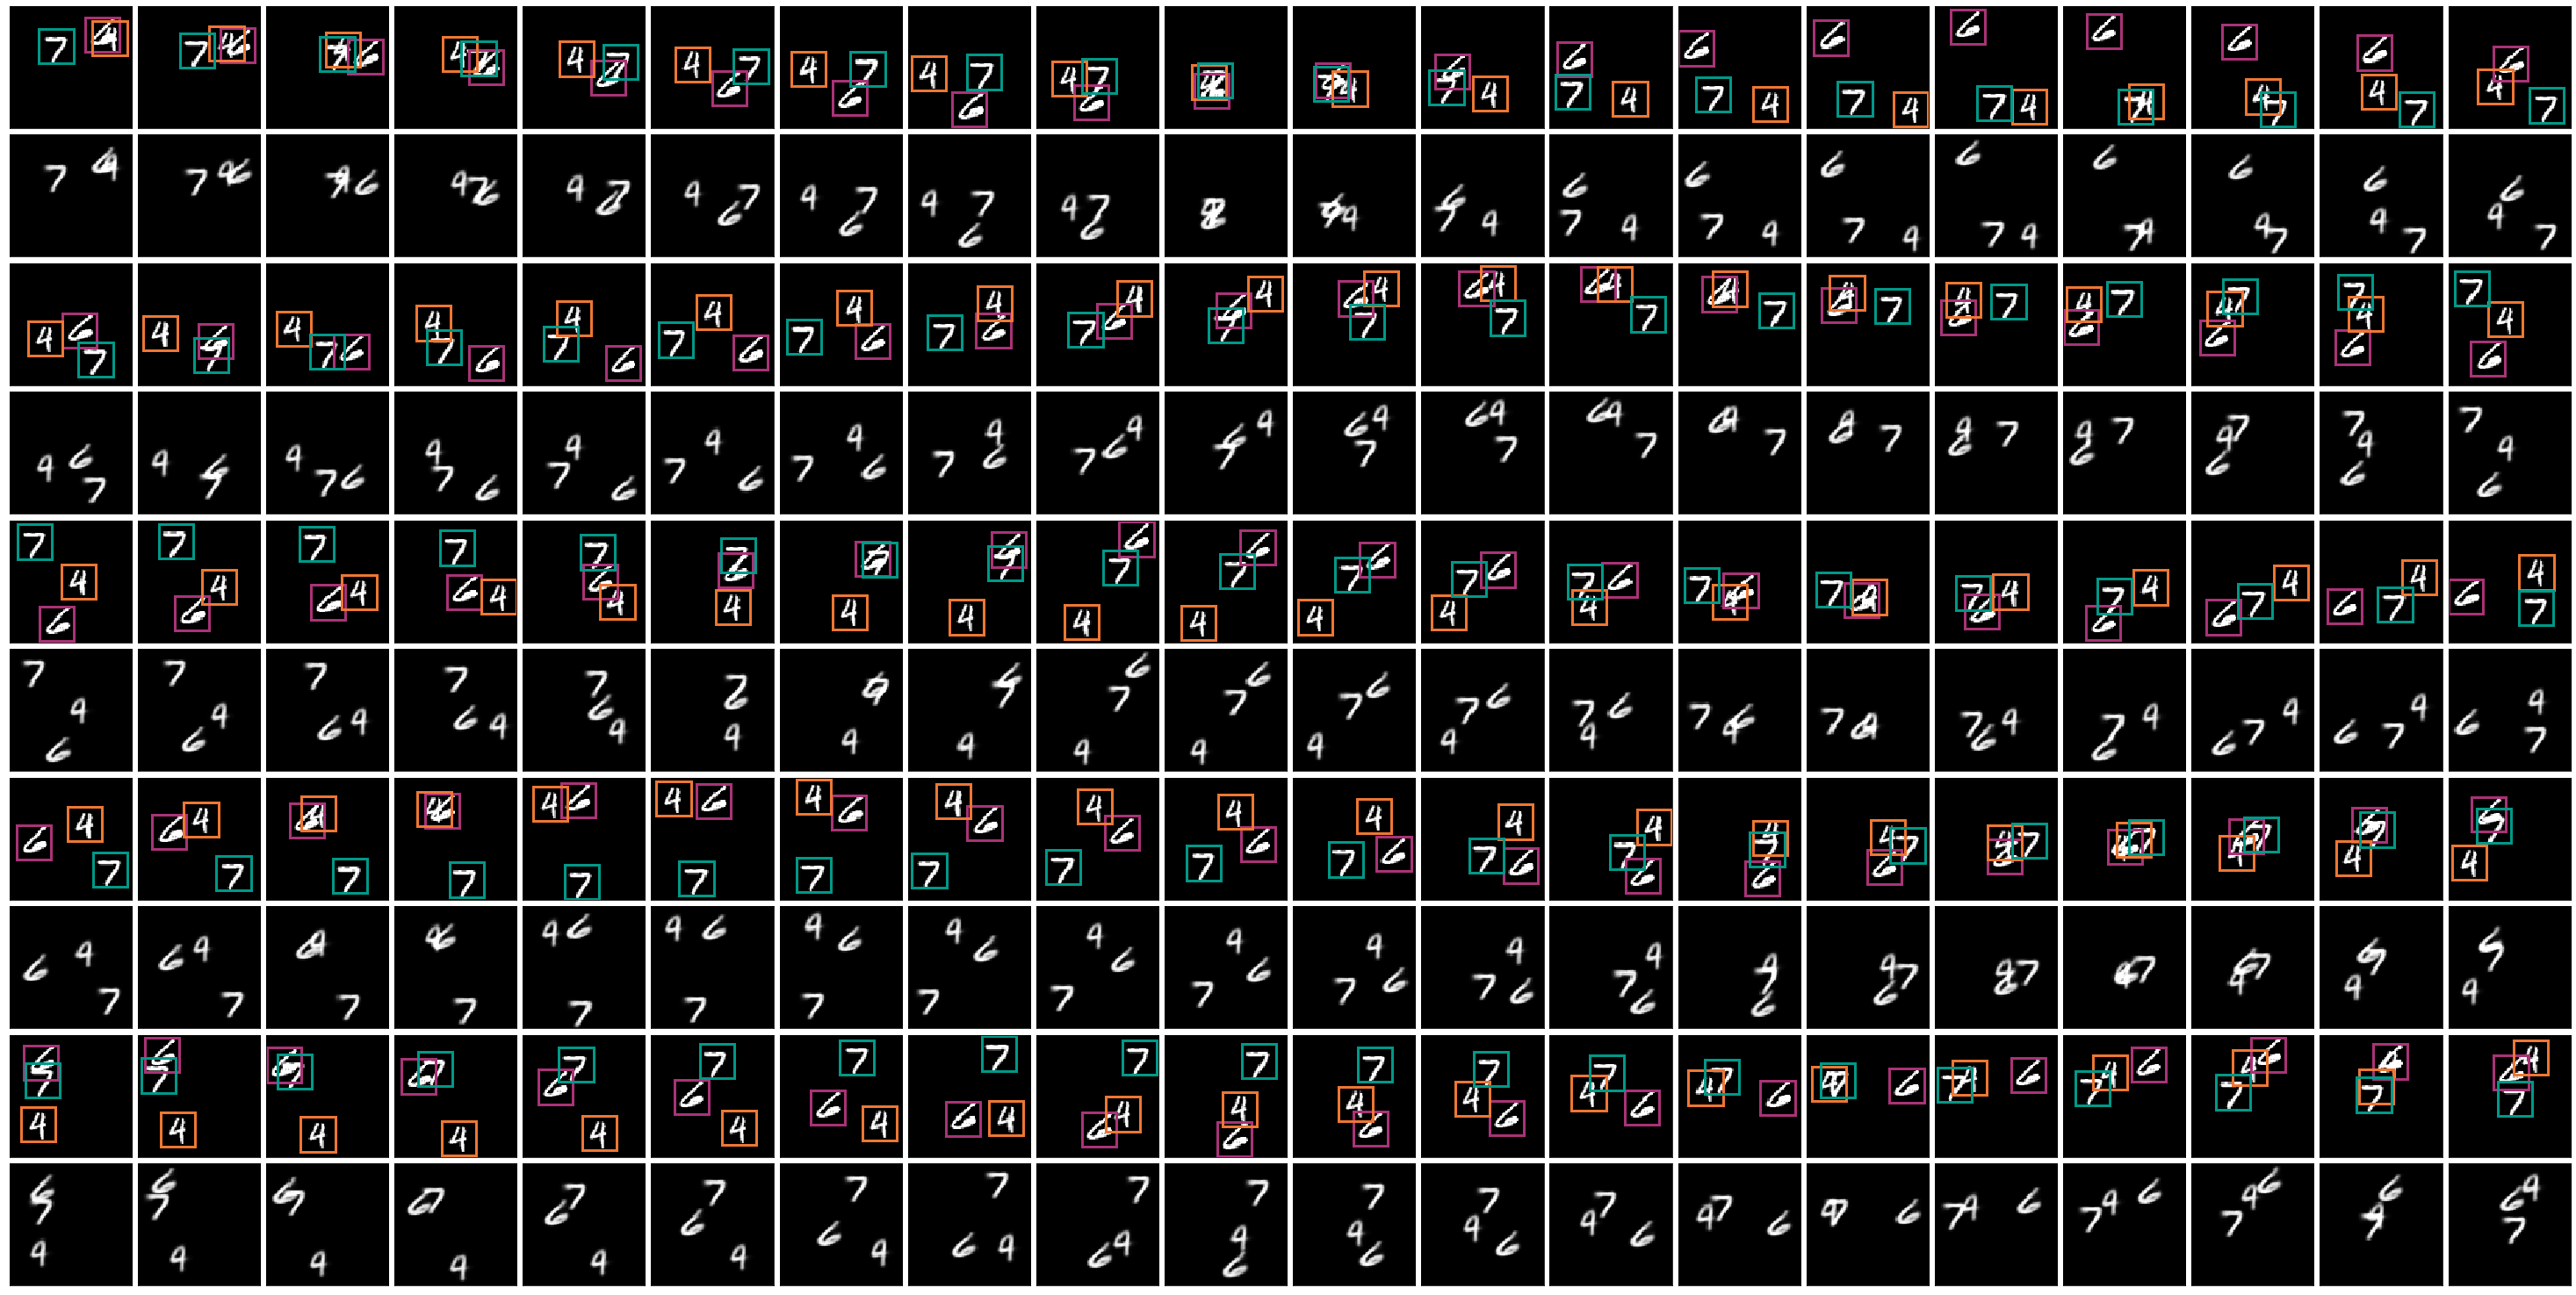

In [9]:
import os
save_path = './%d-%d/' % (GROUP_PTR, DATA_PTR)

visualizer.Plot_long_video(Metrics, PATH=save_path, save_flag=False)

In [ ]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def Save_imgs(Metrics, save_path):
    Data = Metrics['data']
    recons = Metrics['recon'][-1].mean(0).squeeze(0) # T * 96 *96
    z_where = Metrics['E_where'][-1].squeeze(0).clone()
    z_where[:,:,1] =  z_where[:,:,1] * (-1)
    c_pixels = z_where
    c_pixels = (c_pixels + 1.0) * (96 - 28) / 2. # T * K * D

    
    if not os.path.exists(save_path):
        os.mkdir(save_path)
        os.mkdir(save_path + 'data/')
        os.mkdir(save_path + 'recon/')
        os.mkdir(save_path + 'tracking/')
    for t in range(Data.shape[0]):
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(Data[t], cmap='gray')
        plt.savefig(save_path + 'data/%d.svg' % (t+1))
        plt.close()
        fig = plt.figure(figsize=(6,6)) # recon
        ax = fig.add_subplot(111)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(recons[t], cmap='gray')
        plt.savefig(save_path + 'recon/%d.svg' % (t+1))
        plt.close()        

        fig = plt.figure(figsize=(6,6)) # tracking
        ax = fig.add_subplot(111)
        ax.set_xticks([])
        ax.set_yticks([])
        for k in range(K):
            rect_k = patches.Rectangle((c_pixels[t, k, :]), 27, 27, linewidth=LW, edgecolor=COLORS[k],facecolor='none')
            ax.add_patch(rect_k)
        ax.imshow(Data[t], cmap='gray')
        plt.savefig(save_path + 'tracking/%d.svg' % (t+1))
        plt.close()

In [ ]:
Save_imgs(Metrics, save_path)